
# CS412 — Machine Learning — Homework 1  
**Topic:** k-Nearest Neighbors on Fashion-MNIST  
**Author:** Furkan Emre Babadağ  
**Date:** 2025-10-18  




In [1]:

# Reproducibility
import os, random, time
import numpy as np

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

# Imports
import matplotlib.pyplot as plt
from collections import Counter
from typing import Tuple, List

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)
from sklearn.neighbors import KNeighborsClassifier

# Fashion-MNIST via Keras
from tensorflow.keras.datasets import fashion_mnist

# Class label names for Fashion-MNIST 
CLASS_NAMES = [
    "T-shirt/Top", "Trouser", "Pullover", "Dress","Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"    
]

def plot_class_distribution(y, title="Class Distribution"):
    counts = Counter(y.tolist() if hasattr(y, "tolist") else y)
    xs = list(range(10))
    ys = [counts.get(i, 0) for i in xs]
    plt.figure()
    plt.bar(xs, ys)
    plt.xticks(xs, CLASS_NAMES, rotation=45, ha="right")
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

def show_one_sample_per_class(X, y, class_names=CLASS_NAMES):
    # expects X as (N, 28, 28)
    chosen = {}
    for i, label in enumerate(y):
        if label not in chosen:
            chosen[label] = i
        if len(chosen) == len(class_names):
            break

    cols = len(class_names)
    plt.figure(figsize=(cols * 1.6, 1.8))
    for idx, cls in enumerate(sorted(chosen.keys())):
        plt.subplot(1, cols, idx + 1)
        plt.imshow(X[chosen[cls]], cmap="gray")
        plt.axis("off")
        plt.title(f"{class_names[cls]}")
    plt.tight_layout()
    plt.show()

def per_class_mean_intensity(X, y, class_names=CLASS_NAMES):
    # X shape: (N, 28, 28); returns dict of class -> mean pixel
    result = {}
    for cls in range(len(class_names)):
        cls_pixels = X[y == cls].astype(np.float32)
        result[cls] = float(cls_pixels.mean())
    return result

def plot_validation_curve(results_df):
    # One figure; accuracy vs k for each metric
    ks = sorted(results_df["k"].unique())
    metrics = sorted(results_df["metric"].unique())

    plt.figure()
    for metric in metrics:
        mask = results_df["metric"] == metric
        subset = results_df[mask].sort_values("k")
        plt.plot(subset["k"], subset["val_accuracy"], marker="o", label=metric)
    plt.xlabel("k (number of neighbors)")
    plt.ylabel("Validation Accuracy")
    plt.title("Validation Accuracy vs k for Distance Metrics")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, class_names=CLASS_NAMES, title="Confusion Matrix"):
    plt.figure(figsize=(6.5, 6))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha="right")
    plt.yticks(tick_marks, class_names)
    thresh = cm.max() / 2.0 if cm.max() > 0 else 0.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], "d"),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

def top_confused_pairs(cm, top_n=3):
    # Return top-N off-diagonal pairs by count
    off_diag = []
    C = cm.copy()
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            if i != j and C[i, j] > 0:
                off_diag.append(((i, j), int(C[i, j])))
    off_diag.sort(key=lambda x: x[1], reverse=True)
    return off_diag[:top_n]



## 1) Load Fashion-MNIST and Train/Val/Test Split


In [2]:

# Load data
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

# Split train into train/val (80/20), stratified, reproducible
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

print("Shapes:")
print("  Train:", X_train.shape, y_train.shape)
print("  Val:  ", X_val.shape, y_val.shape)
print("  Test: ", X_test.shape, y_test.shape)


Shapes:
  Train: (48000, 28, 28) (48000,)
  Val:   (12000, 28, 28) (12000,)
  Test:  (10000, 28, 28) (10000,)



## 2) Exploratory Data Analysis (Before Preprocessing)



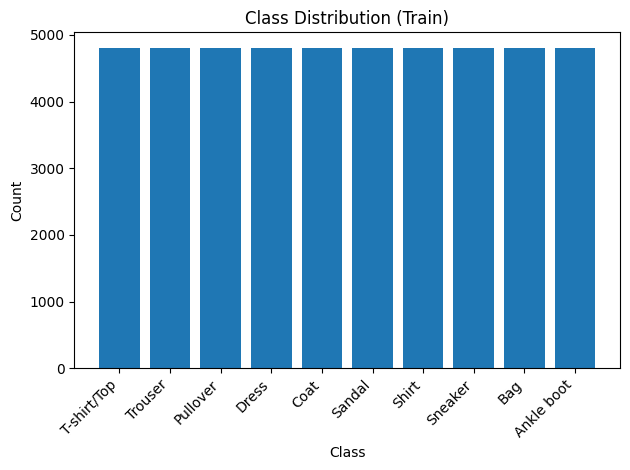

Global pixel mean (train): 72.9944
Global pixel std  (train): 90.0594
Mean intensity — T-shirt/Top : 82.8497
Mean intensity — Trouser     : 56.9871
Mean intensity — Pullover    : 96.4915
Mean intensity — Dress       : 66.1218
Mean intensity — Coat        : 98.1003
Mean intensity — Sandal      : 34.8001
Mean intensity — Shirt       : 84.8261
Mean intensity — Sneaker     : 42.8378
Mean intensity — Bag         : 90.1695
Mean intensity — Ankle boot  : 76.7609


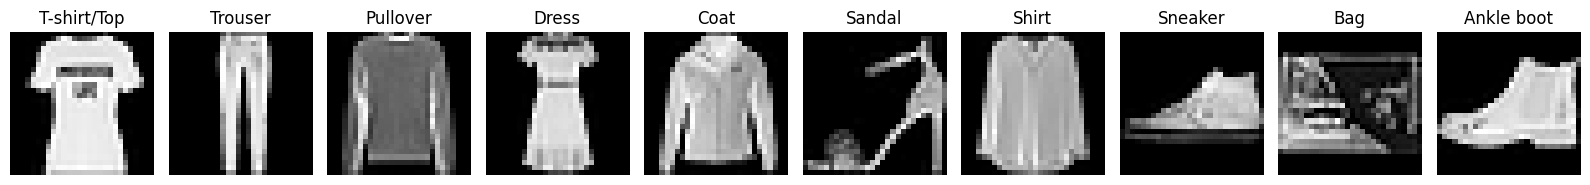

In [3]:

# Class distribution on TRAIN set
plot_class_distribution(y_train, title="Class Distribution (Train)")

# Global pixel statistics (train only)
global_mean = float(X_train.astype(np.float32).mean())
global_std  = float(X_train.astype(np.float32).std())
print(f"Global pixel mean (train): {global_mean:.4f}")
print(f"Global pixel std  (train): {global_std:.4f}")

# Per-class mean pixel intensity (train)
pc_mean = per_class_mean_intensity(X_train, y_train)
for cls_idx, m in pc_mean.items():
    print(f"Mean intensity — {CLASS_NAMES[cls_idx]:<12}: {m:.4f}")

# Show one sample per class (from train)
show_one_sample_per_class(X_train, y_train)



## 3) Preprocessing


In [4]:

# Flatten images
X_train_flat = X_train.reshape(len(X_train), -1).astype(np.float32)
X_val_flat   = X_val.reshape(len(X_val), -1).astype(np.float32)
X_test_flat  = X_test.reshape(len(X_test), -1).astype(np.float32)

# Before scaling stats (train)
pre_mean = float(X_train_flat.mean())
pre_std  = float(X_train_flat.std())
print(f"Before scaling — mean: {pre_mean:.4f}, std: {pre_std:.4f}")

# Scale
scaler = StandardScaler(with_mean=True, with_std=True)
X_train_scaled = scaler.fit_transform(X_train_flat)
X_val_scaled   = scaler.transform(X_val_flat)
X_test_scaled  = scaler.transform(X_test_flat)

# After scaling stats (train)
post_mean = float(X_train_scaled.mean())
post_std  = float(X_train_scaled.std())
print(f"After scaling  — mean: {post_mean:.4f}, std: {post_std:.4f}")


Before scaling — mean: 72.9944, std: 90.0594
After scaling  — mean: 0.0000, std: 1.0000



## 4) k-NN Hyperparameter Tuning



k= 1, metric=euclidean | val_acc=0.8521 | fit=0.031s | pred=6.934s
k= 3, metric=euclidean | val_acc=0.8553 | fit=0.060s | pred=4.327s
k= 5, metric=euclidean | val_acc=0.8548 | fit=0.058s | pred=4.375s
k= 7, metric=euclidean | val_acc=0.8562 | fit=0.058s | pred=4.382s
k= 1, metric=manhattan | val_acc=0.8570 | fit=0.057s | pred=36.836s
k= 3, metric=manhattan | val_acc=0.8631 | fit=0.034s | pred=38.329s
k= 5, metric=manhattan | val_acc=0.8661 | fit=0.050s | pred=35.673s
k= 7, metric=manhattan | val_acc=0.8643 | fit=0.041s | pred=35.826s


,k,metric,val_accuracy,fit_time_s,pred_time_s
0,1,euclidean,0.852083,0.031140,6.934485
1,3,euclidean,0.855333,0.060197,4.327244
2,5,euclidean,0.854833,0.057872,4.374785
3,7,euclidean,0.856250,0.057722,4.381941
4,1,manhattan,0.857000,0.057250,36.835978
5,3,manhattan,0.863083,0.033789,38.329075
6,5,manhattan,0.866083,0.049821,35.673225
7,7,manhattan,0.864333,0.040909,35.826100


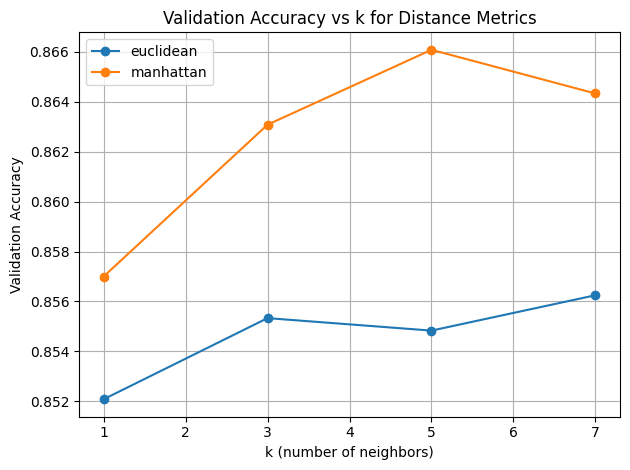

Best params -> k=5, metric=manhattan


In [5]:

import pandas as pd

results = []
metrics = ["euclidean", "manhattan"]
k_values = [1, 3, 5, 7]

for metric in metrics:
    for k in k_values:
        clf = KNeighborsClassifier(n_neighbors=k, metric=metric, n_jobs=-1)
        t0 = time.time()
        clf.fit(X_train_scaled, y_train)
        fit_time = time.time() - t0

        t1 = time.time()
        y_val_pred = clf.predict(X_val_scaled)
        pred_time = time.time() - t1

        acc = accuracy_score(y_val, y_val_pred)
        results.append({
            "k": k,
            "metric": metric,
            "val_accuracy": acc,
            "fit_time_s": fit_time,
            "pred_time_s": pred_time
        })
        print(f"k={k:>2}, metric={metric:<9} | val_acc={acc:.4f} | fit={fit_time:.3f}s | pred={pred_time:.3f}s")

results_df = pd.DataFrame(results)
display(results_df.sort_values(["metric", "k"]).reset_index(drop=True))

# Plot validation curve
plot_validation_curve(results_df)

# Pick best by highest val_accuracy; tie-breaker: smaller k, then euclidean first
best = results_df.sort_values(
    by=["val_accuracy", "k", "metric"], ascending=[False, True, True]
).iloc[0]
best_k = int(best["k"])
best_metric = str(best["metric"])
print(f"Best params -> k={best_k}, metric={best_metric}")



## 5) Final Model — Train on (Train + Val), Evaluate on Test



Test Accuracy: 0.8614
Macro Precision: 0.8626
Macro Recall:    0.8614
Macro F1-score:  0.8610
Final fit time (s):   0.034
Final predict time(s): 41.827


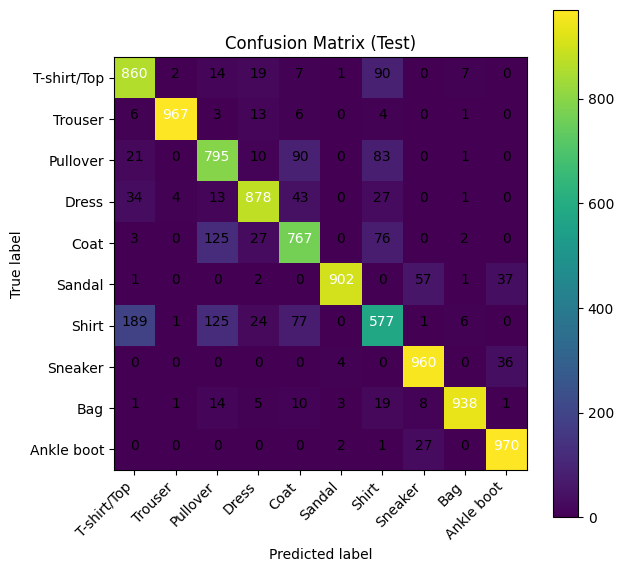


Classification Report (Test):

              precision    recall  f1-score   support

 T-shirt/Top       0.77      0.86      0.81      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.73      0.80      0.76      1000
       Dress       0.90      0.88      0.89      1000
        Coat       0.77      0.77      0.77      1000
      Sandal       0.99      0.90      0.94      1000
       Shirt       0.66      0.58      0.61      1000
     Sneaker       0.91      0.96      0.94      1000
         Bag       0.98      0.94      0.96      1000
  Ankle boot       0.93      0.97      0.95      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

k-NN is a lazy learner because it does not build an explicit parametric model during training;
instead, it stores the training data and defers most computation to prediction time,
where distances to many point

In [6]:

# Concatenate train and val
X_trval = np.vstack([X_train_flat, X_val_flat])
y_trval = np.concatenate([y_train, y_val])

# Scale using scaler fitted on TRAIN (as above, we must refit on Train+Val to avoid leakage?)
# To follow the typical pipeline after model selection, we refit the scaler on Train+Val.
scaler_final = StandardScaler(with_mean=True, with_std=True)
X_trval_scaled = scaler_final.fit_transform(X_trval.astype(np.float32))
X_test_scaled_final = scaler_final.transform(X_test_flat.astype(np.float32))

# Train with best params
clf_final = KNeighborsClassifier(n_neighbors=best_k, metric=best_metric, n_jobs=-1)

t0 = time.time()
clf_final.fit(X_trval_scaled, y_trval)
fit_time_final = time.time() - t0

t1 = time.time()
y_test_pred = clf_final.predict(X_test_scaled_final)
pred_time_final = time.time() - t1

# Metrics
acc = accuracy_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred, average="macro", zero_division=0)
rec  = recall_score(y_test, y_test_pred, average="macro", zero_division=0)
f1   = f1_score(y_test, y_test_pred, average="macro", zero_division=0)

print(f"Test Accuracy: {acc:.4f}")
print(f"Macro Precision: {prec:.4f}")
print(f"Macro Recall:    {rec:.4f}")
print(f"Macro F1-score:  {f1:.4f}")
print(f"Final fit time (s):   {fit_time_final:.3f}")
print(f"Final predict time(s): {pred_time_final:.3f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(cm, class_names=CLASS_NAMES, title="Confusion Matrix (Test)")

# Classification report (printed)
print("\nClassification Report (Test):\n")
print(classification_report(y_test, y_test_pred, target_names=CLASS_NAMES, zero_division=0))
print("k-NN is a lazy learner because it does not build an explicit parametric model during training;")
print("instead, it stores the training data and defers most computation to prediction time,")
print("where distances to many points are computed to find nearest neighbors.")



## 6) Error Analysis



Top confused pairs (true -> pred) with counts:
  Shirt -> T-shirt/Top: 189
  Coat -> Pullover: 125
  Shirt -> Pullover: 125


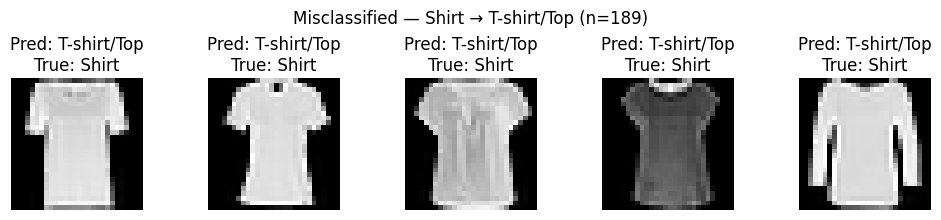

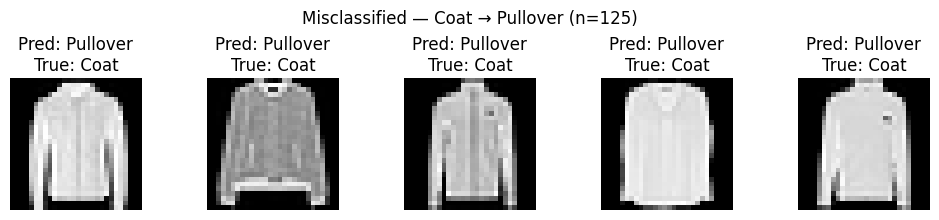

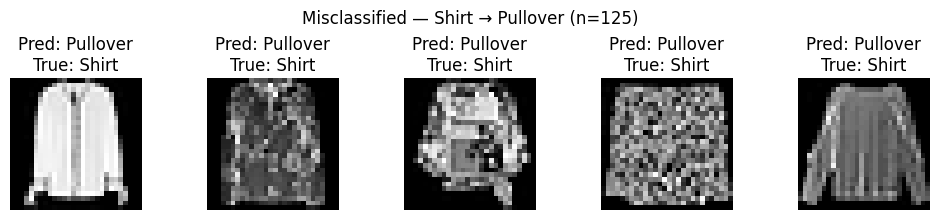

Discussion ideas:
- Classes with similar silhouettes (e.g., T-shirt/Top vs Shirt, Pullover vs Coat).
- Texture & material cues are weak in 28×28 grayscale images.
- k and metric choices may emphasize local neighborhoods that blur class boundaries.


In [ ]:

# Find top-3 confused pairs
pairs = top_confused_pairs(cm, top_n=3)
print("Top confused pairs (true -> pred) with counts:")
for (i, j), c in pairs:
    print(f"  {CLASS_NAMES[i]} -> {CLASS_NAMES[j]}: {c}")

# Gather indices of misclassifications for each pair and visualize 5 examples
rng = np.random.default_rng(SEED)

for (true_c, pred_c), count in pairs:
    # find indices in test set where y_true=true_c and y_pred=pred_c
    idxs = np.where((y_test == true_c) & (y_test_pred == pred_c))[0]
    if len(idxs) == 0:
        continue
    chosen = rng.choice(idxs, size=min(5, len(idxs)), replace=False)

    plt.figure(figsize=(10, 2.2))
    for k, idx in enumerate(chosen, start=1):
        plt.subplot(1, min(5, len(chosen)), k)
        plt.imshow(X_test[idx], cmap="gray")
        plt.axis("off")
        plt.title(f"Pred: {CLASS_NAMES[pred_c]}\nTrue: {CLASS_NAMES[true_c]}")
    plt.suptitle(f"Misclassified — {CLASS_NAMES[true_c]} → {CLASS_NAMES[pred_c]} (n={len(idxs)})")
    plt.tight_layout()
    plt.show()

print("Discussion ideas:")
print("- Similarity in silhouettes.")
print("- Texture & material cues are weak in 28×28 grayscale images.")
print("- k and metric choices may emphasize local neighborhoods that blur class boundaries.")
